In [13]:
## Analysis of 3d Truss structures
# TC v6.0

# inputModel - folder name
# inputUnit - m or mm
# plotParam - dictionary


[[ 1.          0.500011   -0.         -0.         -0.         -0.
  -0.        ]
 [-0.          0.86601905 -0.         -0.         -0.         -0.
  -0.        ]
 [-1.         -0.          1.         -0.500011    0.500011   -0.
  -0.        ]
 [-0.         -0.         -0.          0.86601905  0.86601905 -0.
  -0.        ]
 [-0.         -0.         -1.         -0.         -0.         -0.500011
  -0.        ]
 [-0.         -0.         -0.         -0.         -0.          0.86601905
  -0.        ]
 [-0.         -0.500011   -0.          0.500011   -0.         -0.
   1.        ]
 [-0.         -0.86601905 -0.         -0.86601905 -0.         -0.
  -0.        ]
 [-0.         -0.         -0.         -0.         -0.500011    0.500011
  -1.        ]
 [-0.         -0.         -0.         -0.         -0.86601905 -0.86601905
  -0.        ]]
Equilibrium (Af+F)^2 MSE=1.307137621137016e-21
Compatibility (Bf+A^Tu)^2 MSE=4.237045877651919e-33
Stiffness mean (Ku-F)^2 MSE=5.270085875756272e-22


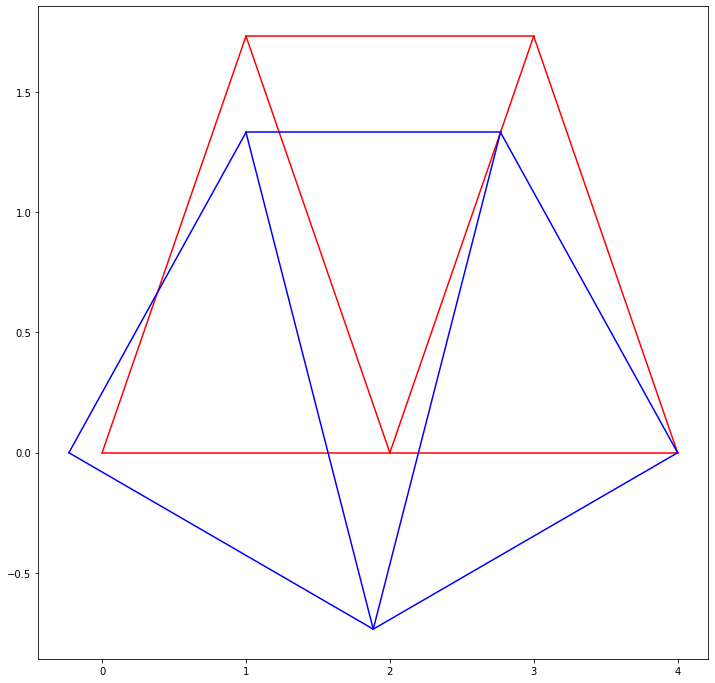

In [35]:
#from trussFEM import *

import sys, os
import numpy as np
## Analysis of 3d Truss structures

# inputModel - folder name
# inputUnit - m or mm
# inputPlot - 0 - no plot, 1 - plot

# Folder containing all your models
inputFolder='input/'
# Sub folder containing the particular model for analysis
inputModel='7_bar_2D/'
# Sub sub folder containing either input files in SI (N,m,kg,PA) or in MPa (N, mm, tonnes, MPA) units
inputUnit='m'
# Whether to plot results or not
inputPlot=1

# tog - plot ON/OFF, deform shape , modal shape, modal #, scale of def, color 1=stress, 2=mat
plotting = dict()
plotting['IO']=True # true - plot, false - do not plot
plotting['deformed']= 2 # 0 - original, 1 - deformed, 2 - both

[glb,elem,num] = trussFEM(inputFolder, inputModel, inputUnit, plotting)


In [34]:
import numpy as np
import json
from scipy.sparse import coo_matrix


# plot 3D figure with the truss members in undeformed, and in deformed configurations
def plotStructFun(glb, elem, inputData, plotting):
    
    from mpl_toolkits import mplot3d
    import matplotlib.pyplot as plt
    
    deformation = inputData['nodes'] + np.reshape(glb['u'],(-1,2)) # from number of nodes x 3 to number of DOF x 1, in a [x0,y0,z0,x1,y1,z1]
    
    fig = plt.figure(figsize=(12, 12))
    ax = plt.axes()

    if plotting['deformed'] == 0 or plotting['deformed'] == 2:
        for n0,n1 in zip(elem['n0'],elem['n1']):
            x = [[inputData['nodes'][n0][i], inputData['nodes'][n1][i]] for i in [0,1]]
            ax.plot(x[0],x[1], c='r')

    if plotting['deformed'] == 1 or plotting['deformed'] == 2:
        for n0,n1 in zip(elem['n0'],elem['n1']):
            x = [[deformation[n0][i], deformation[n1][i]] for i in [0,1]]
            ax.plot(x[0],x[1], c='b')

    plt.show()
    
def importData(cwd):
    inputDataNames =['members', 'constraints', 'nodes', 'forces']
    
    inputData = dict()
    num = dict()
    
    for dataName in inputDataNames:
        inputData[dataName] = np.genfromtxt(cwd+'/'+dataName+'.csv', delimiter=',')
        if len(np.shape(inputData[dataName])) == 1:
            numDim = 1
        else:
            numDim = np.shape(inputData[dataName])[0]
        num[dataName[0]] = numDim

    # reading parameter data
    with open(cwd+'/'+'parameters.csv') as f:
        inputData['parameters'] = json.loads(f.read())
        
    return [inputData, num]
    
def initializeStruct(inputData,num):

    num['nDOF'] = 2 # nodal DOF
    num['lDOF'] = 2*num['nDOF'] # elemental DOF (there are two nodes per members)
    num['DOF']  = num['n']*num['nDOF'] # global DOF

    elem = dict()
    
    # Assemble global connectivity matrix
    elem['A']   = inputData['members'][:,2]
    elem['E']   = inputData['members'][:,3]
    elem['rho'] = np.ones(num['m'])*inputData['parameters']['rho']

    elem['n0']  = np.array(inputData['members'][:,0], dtype=np.int8)
    elem['n1']  = np.array(inputData['members'][:,1], dtype=np.int8)
    
    ##
    # $$u_y = \frac{f_y}{E}$$
    
    glb = dict()

    # initial force vector
    glb['F_init'] = assembleBC(inputData['forces'],num,'F')

    # initial displacement vector
    glb['u_init'] = assembleBC(inputData['constraints'],num,'u')
    
    glb['F'] = np.zeros(num['DOF'])
    glb['u'] = np.array(np.ones(num['DOF']) * np.inf)
                        
    # Find the indices of the u inits that are inf (free), or not
    glb['fDOF'] = np.where(glb['u_init'] == -np.inf)[0] # these dofs are free
    glb['pDOF'] = np.where(glb['u_init'] != -np.inf)[0] # these dofs are constrained

    # number of free and prescribed DOFs
    num['fDOF'] = len(glb['fDOF'])
    num['pDOF'] = len(glb['pDOF'])
    
    return [glb, elem, num]
    
    
def assembleA(num, nodes, n0,n1):

    data = np.hstack((-1*np.ones(num['m'], dtype=np.int8), np.ones(num['m'], dtype=np.int8))) # data -1 and 1 [2*m x 1]

    row  = np.arange(0,num['m'])
    row  = np.hstack((row,row))
    
    #cols = [n0,n1] # cols - node col # [2*n x 1]
    col  = np.hstack((n0,n1))

    C   = coo_matrix((data, (row, col)), shape=(num['m'],num['n'])).toarray()  # connectivity matrix [m x n]

    u    = np.matmul(C,nodes) # [m x n] x [n x 2] --> [m x 2]

    U    = coo_matrix((u[:,0],(np.arange(num['m']),np.arange(num['m']))), shape=(num['m'],num['m'])).toarray()  # [mxm]
    V    = coo_matrix((u[:,1],(np.arange(num['m']),np.arange(num['m']))), shape=(num['m'],num['m'])).toarray()  # [mxm]

    eL   = np.sum(u**2,axis=-1)**(1./2)# element length
    
    L    = np.diag(eL) # diagonalize eL
    
    [Dx,Dy] = [np.matmul(np.matmul(C.transpose(),x),np.linalg.inv(L))  for x in [U,V]]# [n x m][m x m][m x m] 
    
    AKm = np.zeros((num['DOF'],num['m']))

    AKm[0::2,:] = Dx
    AKm[1::2,:] = Dy
    
    AKm = -AKm
    
    print(AKm)
    return [C, AKm,eL]
    
def SolverLE(glb, elem, num):
    # FEM Analysis
    #
    # $$B_{i,i}=\frac{L_i^2}{E_it_i}\,\quad k=1,...,m$$
    #
    # $$K=AB^{-1}A^{T}$$
    #
    # $$Ku=F$$
    #
    # $$s=\frac{1}{2}u^TKu$$
    f_id  = np.ix_(glb['fDOF'])
    p_id  = np.ix_(glb['pDOF'])
    ff_id = np.ix_(glb['fDOF'],glb['fDOF'])
    fp_id = np.ix_(glb['fDOF'],glb['pDOF'])
    pf_id = np.ix_(glb['pDOF'],glb['fDOF'])
    pp_id = np.ix_(glb['pDOF'],glb['pDOF'])
    
    # Solve for the unknown displacements
    glb['u'][f_id]=np.linalg.solve(glb['Km'][ff_id], glb['F_init'][f_id]-np.matmul(glb['Km'][fp_id],glb['u'][p_id])) # K11 x u1 = F1 - K12 x u2
    # Solve for reaction
    glb['F'][p_id]=np.matmul(glb['Km'][pf_id], glb['u'][f_id]) + np.matmul(glb['Km'][pp_id], glb['u'][p_id])

    ## Post processing
    
    elem['f']=-1/2 * elem['BKm'] * (np.matmul(glb['AKm'][f_id].transpose(), glb['u'][f_id])+np.matmul(glb['AKm'][f_id].transpose(), glb['u'][f_id])) # member force
    
    elem['stress'] = elem['f'] / elem['A'] # member stress
    elem['strain'] = elem['stress'] / elem['E'] # member strain
    
    # calculate element wise displacement
    elem['d'] = -np.matmul(glb['AKm'][f_id].transpose(), glb['u'][f_id]) # displacement in member - A^T*u
    #elem['d'] = elem['strain'] * eL # displacement in member - epsilon * L
    
    # Check if the calculations were correct
    status = dict()
    status['equilibrium']   = sum((np.matmul(glb['AKm'][f_id],elem['f'])+glb['F'][f_id])**2)
    status['compatibility'] = sum((np.matmul(np.diag(elem['BKm']**-1),elem['f'])+np.matmul(glb['AKm'][f_id].transpose(),glb['u'][f_id]))**2)
    status['stiffness']     = sum((glb['F'][f_id]-np.matmul(glb['Km'][ff_id],glb['u'][f_id]))**2)
    
    return [glb,elem,status]
    
def assembleBC(table,num,BC):
    if BC == 'u':
        out   = np.zeros(num['DOF'])-np.inf
        numBC = num['c']
    elif BC == 'F':
        out   = np.zeros(num['DOF'])
        numBC = num['f']
    
    for i in np.arange(0,numBC):
        if numBC == 1:
            n  = table[0]
            d  = table[1:3]
            m  = table[3]
        else:
            n  = table[i,0]
            d  = table[i,1:3]
            m  = table[i,3]
        for row in np.arange(0,num['nDOF']):
                if d[row] == 1:
                    idx = int(num['nDOF']*n+row)
                    out[idx] = m
    return out

def assembleKm(AKm, BKm, num):
    # glb.Km=np.array((num['DOF'],num['DOF']))
    # for k in np.arange(0, num['m']-1):
        # km=elem(k).A*elem(k).Et/l(k)*glb.b_l
        # Km=elem(k).T.'*km*elem(k).T
        # [glb.Km]=assembleId(num.nDOF,n1(k),n2(k),glb.Km,Km)
        
    # [n x n] = [n x m] x [m x m] x [m x n]
    Km  = np.matmul(np.matmul(AKm, np.diag(BKm)), AKm.transpose())
    return Km

def trussFEM(inputFolder, inputModel, inputUnit, plotting):

    # Read data from file and put all in matlab tables
    cwd=inputFolder+inputModel+inputUnit

    [inputData, num] = importData(cwd)

    # Initialization of material and geometrical properties
    # Initialize # of DOF, calculate elem. and glb. DOF, and material yield strength, stiffness, and cross sectional area
    # Construct a struct containing all of this information per element
    [glb, elem, num] = initializeStruct(inputData, num)
    
    [glb['C'], glb['AKm'], elem['L']] = assembleA(num, inputData['nodes'], elem['n0'],elem['n1'])
    
    elem['BKm'] = elem['E']*elem['A']/elem['L']
    
    glb['Km']   = assembleKm(glb['AKm'],elem['BKm'], num)

    glb['F'] = glb['F_init']
    glb['u'] = glb['u_init']
    
    [glb,elem,status] = SolverLE(glb, elem, num)
    glb['Volume']=sum(elem['A']*elem['L'])
    glb['Mass']=sum(elem['A']*elem['L']*elem['rho'])

    # Equilibrium, compatibility and stiffness check
    print('Equilibrium (Af+F)^2 MSE='      + str(status['equilibrium']))
    print('Compatibility (Bf+A^Tu)^2 MSE=' + str(status['compatibility']))
    print('Stiffness mean (Ku-F)^2 MSE='   + str(status['stiffness']))
    
    if plotting['IO']==True:
        plotStructFun(glb, elem, inputData, plotting)

    return [glb,elem,num]